In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

sns.set_style('whitegrid')
pd.set_option('display.max_rows', None)

In [88]:
data = pd.read_parquet('n_forecast_preprocessed.parquet', engine='pyarrow', dtype_backend='numpy_nullable')

In [89]:
data.head()

,sales_date,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,...,holiday_valentines_day,autumn_school_holiday,summer_school_holiday,spring_school_holiday,christmas_school_holiday,may_school_holiday,easter_school_holiday,datetime_store_open,datetime_store_closed,working_hours
0,2019-01-02,b9d487a30398d42ecff55c228ed5652b,6570,19,68,south,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
1,2019-01-02,c3e0c62ee91db8dc7382bde7419bb573,1773,6,30,middle,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
2,2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,19,10,north,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
3,2019-01-02,07042ac7d03d3b9911a00da43ce0079a,5391,19,10,north,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
4,2019-01-02,b60c5ab647a27045b462934977ccad9a,2789,6,96,north,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0


In [90]:
# select store 90db9da4fc5414ab55a9fe495d555c06

store_data = data[data['store_hashed'] == '90db9da4fc5414ab55a9fe495d555c06']

In [91]:
store_data.head()

,sales_date,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,...,holiday_valentines_day,autumn_school_holiday,summer_school_holiday,spring_school_holiday,christmas_school_holiday,may_school_holiday,easter_school_holiday,datetime_store_open,datetime_store_closed,working_hours
2,2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,19,10,north,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
1355,2019-05-19,90db9da4fc5414ab55a9fe495d555c06,8350,19,10,north,0,0,0,0,...,0,0,0,0,0,0,0,2019-05-19 09:00:00,2019-05-19 22:00:00,13.0
1670,2019-06-22,90db9da4fc5414ab55a9fe495d555c06,9424,19,10,north,0,0,0,0,...,0,0,0,0,0,0,0,2019-06-22 08:00:00,2019-06-22 22:00:00,14.0
2360,2019-08-30,90db9da4fc5414ab55a9fe495d555c06,9798,19,10,north,0,0,0,0,...,0,0,0,0,0,0,0,2019-08-30 08:00:00,2019-08-30 22:00:00,14.0
3694,2020-01-18,90db9da4fc5414ab55a9fe495d555c06,9092,19,10,north,0,0,0,0,...,0,0,0,0,0,0,0,2020-01-18 08:00:00,2020-01-18 22:00:00,14.0


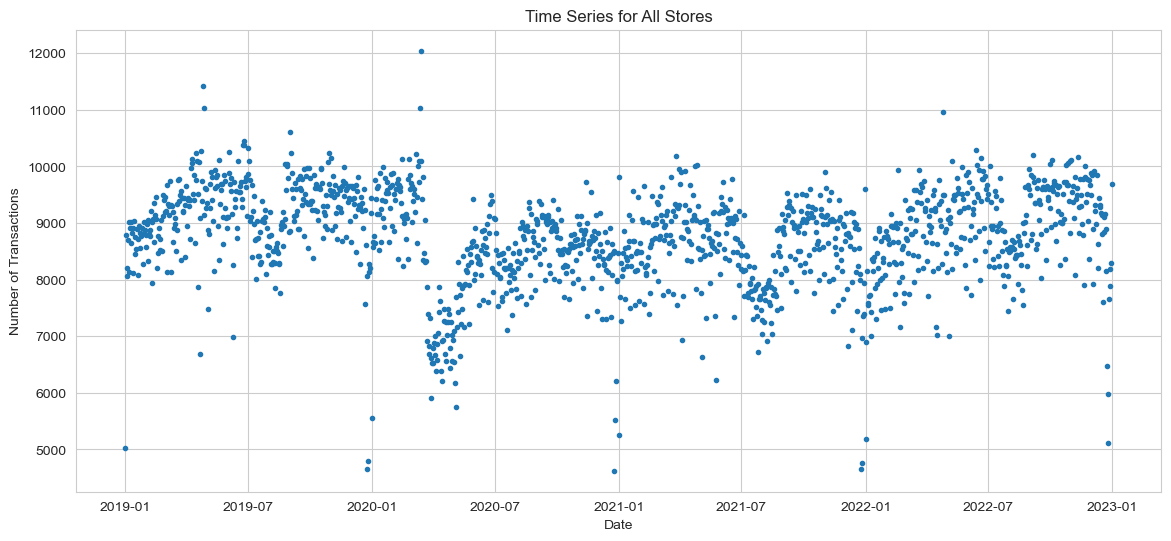

In [92]:
# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(store_data['sales_date'], store_data['n_transactions'], marker='.', linestyle='None')
plt.title('Time Series for All Stores')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()


In [93]:
# Trend, Seasonality, and Noise


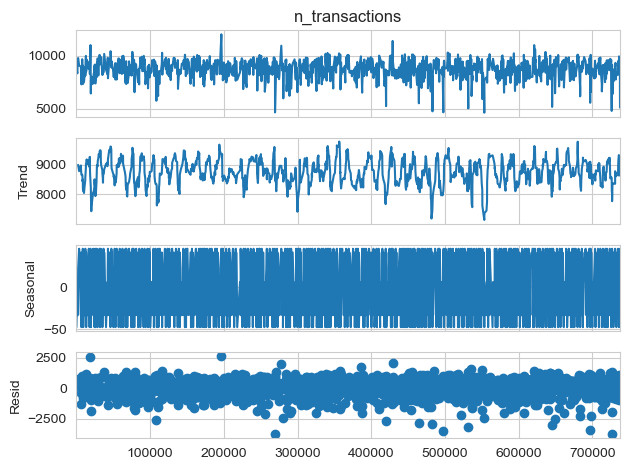

In [94]:
# Seasonal Decomposition
result = seasonal_decompose(store_data['n_transactions'], model='additive', period=7)
result.plot()
plt.show()


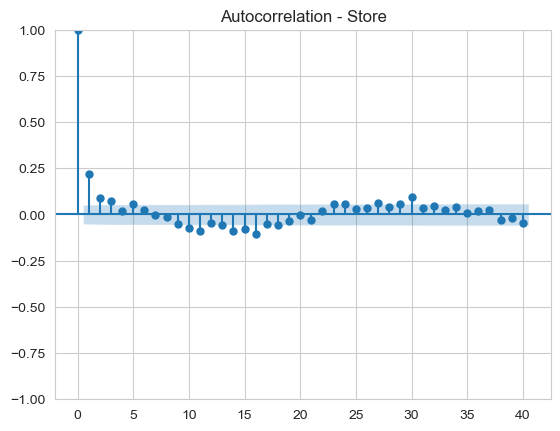

In [95]:
# Auto-correlation plot
plot_acf(store_data['n_transactions'], lags=40)
plt.title(f'Autocorrelation - Store')
plt.show()

In [96]:
trend = result.trend
seasonality = result.seasonal

# Fill missing values in the 'store_trend' column with the mean value
trend = trend.fillna(trend.mean())

# Rename the 'trend' column to 'store_trend'
trend = trend.rename('store_trend')

# Add the trend and seasonality columns to the store_data dataframe
store_data = pd.concat([store_data, trend, seasonality], axis=1)

In [97]:
store_data.head()

,sales_date,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,...,summer_school_holiday,spring_school_holiday,christmas_school_holiday,may_school_holiday,easter_school_holiday,datetime_store_open,datetime_store_closed,working_hours,store_trend,seasonal
2,2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,19,10,north,0,0,0,0,...,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0,8753.857536,-47.289082
1355,2019-05-19,90db9da4fc5414ab55a9fe495d555c06,8350,19,10,north,0,0,0,0,...,0,0,0,0,0,2019-05-19 09:00:00,2019-05-19 22:00:00,13.0,8753.857536,5.951989
1670,2019-06-22,90db9da4fc5414ab55a9fe495d555c06,9424,19,10,north,0,0,0,0,...,0,0,0,0,0,2019-06-22 08:00:00,2019-06-22 22:00:00,14.0,8753.857536,-33.249708
2360,2019-08-30,90db9da4fc5414ab55a9fe495d555c06,9798,19,10,north,0,0,0,0,...,0,0,0,0,0,2019-08-30 08:00:00,2019-08-30 22:00:00,14.0,8992.857143,21.658720
3694,2020-01-18,90db9da4fc5414ab55a9fe495d555c06,9092,19,10,north,0,0,0,0,...,0,0,0,0,0,2020-01-18 08:00:00,2020-01-18 22:00:00,14.0,8781.714286,45.193747


# Forecasting with Prophet

In [98]:
# Create a new instance of the Prophet class
model = Prophet()

In [99]:
# Add the trend and seasonality components as regressors to the model
model.add_regressor('store_trend')
model.add_regressor('seasonal')

In [100]:
# Prepare data for prophet
store_data = store_data[['sales_date', 'store_hashed', 'n_transactions', 'store_trend', 'seasonal']]
store_data.rename(columns={'sales_date': 'ds', 'n_transactions': 'y'}, inplace=True)

In [101]:
store_data.head()

,ds,store_hashed,y,store_trend,seasonal
2,2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,8753.857536,-47.289082
1355,2019-05-19,90db9da4fc5414ab55a9fe495d555c06,8350,8753.857536,5.951989
1670,2019-06-22,90db9da4fc5414ab55a9fe495d555c06,9424,8753.857536,-33.249708
2360,2019-08-30,90db9da4fc5414ab55a9fe495d555c06,9798,8992.857143,21.658720
3694,2020-01-18,90db9da4fc5414ab55a9fe495d555c06,9092,8781.714286,45.193747


In [102]:
model.fit(store_data)

09:54:24 - cmdstanpy - INFO - Chain [1] start processing


09:54:25 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
future = model.make_future_dataframe(periods=50)
future['store_trend'] = trend.values.tolist() + [trend.mean()] * 50
seasonal_values = result.seasonal.values.tolist()
seasonal_values += [result.seasonal.mean()] * (future.shape[0] - len(seasonal_values))
future['seasonal'] = seasonal_values

In [104]:
forecast = model.predict(future)

/Users/dim__gag/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/dim__gag/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


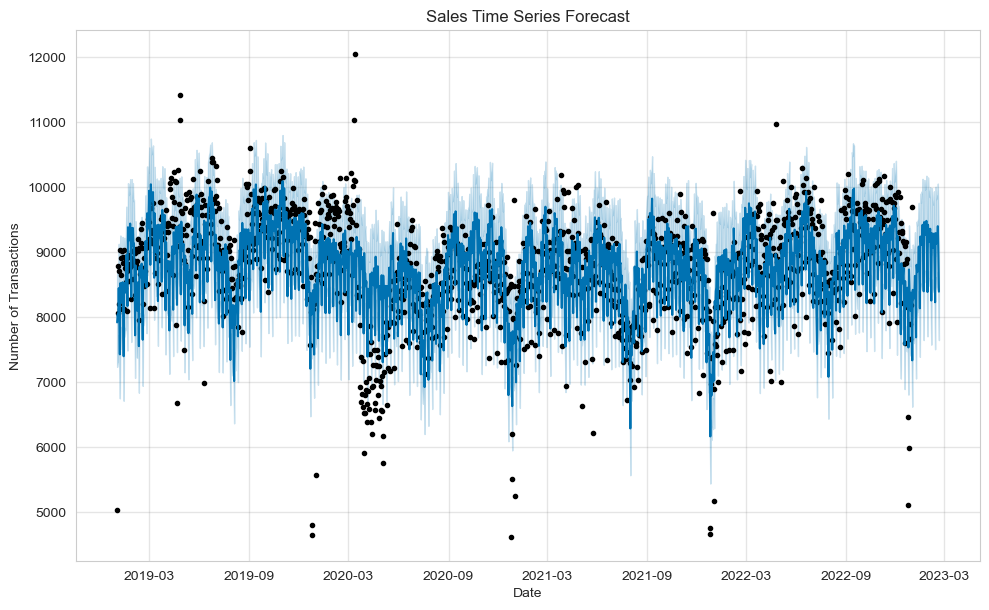

In [105]:
# Plot the forecast
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Sales Time Series Forecast')
plt.show()

In [108]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation on the historical data
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Compute the performance metrics
df_p = performance_metrics(df_cv)

  0%|          | 0/3 [00:00<?, ?it/s]

09:56:29 - cmdstanpy - INFO - Chain [1] start processing
09:56:29 - cmdstanpy - INFO - Chain [1] done processing
09:56:30 - cmdstanpy - INFO - Chain [1] start processing
09:56:30 - cmdstanpy - INFO - Chain [1] done processing
09:56:30 - cmdstanpy - INFO - Chain [1] start processing
09:56:30 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,3.166329e+05,562.701437,454.240658,0.057918,0.048997,0.055692,0.813456
1,38 days,3.075494e+05,554.571405,454.545823,0.057425,0.052214,0.055419,0.813456
2,39 days,3.147517e+05,561.027378,460.514442,0.058209,0.052214,0.056153,0.807339
3,40 days,3.289398e+05,573.532767,470.549069,0.059444,0.055378,0.057318,0.798165
4,41 days,3.279116e+05,572.635632,469.652153,0.059369,0.054786,0.057216,0.798165
5,42 days,3.246855e+05,569.811787,467.469913,0.059120,0.054786,0.056992,0.795107
6,43 days,3.290718e+05,573.647822,473.391261,0.059743,0.054786,0.057629,0.788991
7,44 days,3.306974e+05,575.062979,472.230952,0.059600,0.052214,0.057477,0.779817
8,45 days,3.395986e+05,582.750908,478.470865,0.060178,0.052214,0.058055,0.770642
9,46 days,3.502569e+05,591.825018,488.985390,0.061383,0.054786,0.059272,0.752294


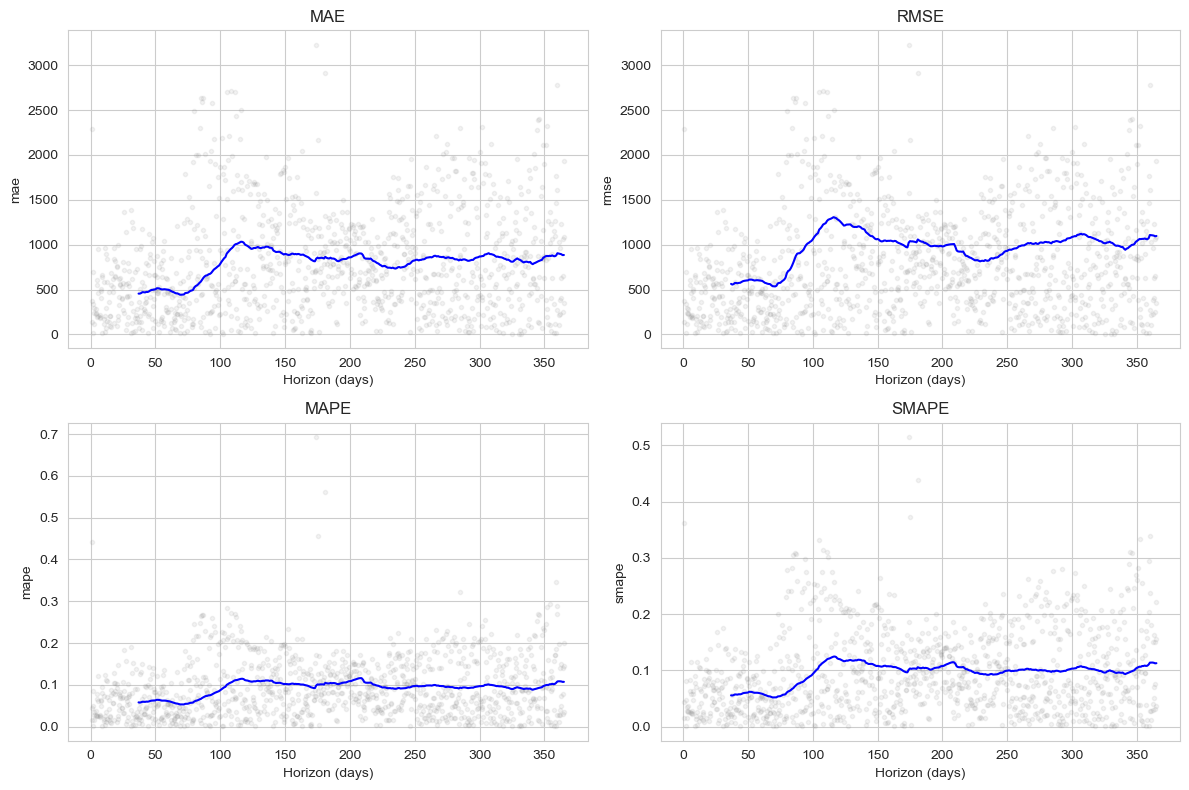

In [115]:
from prophet.plot import plot_cross_validation_metric
# Create a 2 by 2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the performance metrics in the subplots
plot_cross_validation_metric(df_cv, metric='mae', ax=axs[0, 0])
axs[0, 0].set_title('MAE')

plot_cross_validation_metric(df_cv, metric='rmse', ax=axs[0, 1])
axs[0, 1].set_title('RMSE')

plot_cross_validation_metric(df_cv, metric='mape', ax=axs[1, 0])
axs[1, 0].set_title('MAPE')

plot_cross_validation_metric(df_cv, metric='smape', ax=axs[1, 1])
axs[1, 1].set_title('SMAPE')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

The performance metrics provide a quantitative measure of how well the Prophet model is able to forecast the future values of the time series. Here's a brief explanation of each of the performance metrics:

- Mean Absolute Error (MAE): The MAE measures the average absolute difference between the predicted values and the actual values. A lower MAE indicates better performance.

- Root Mean Squared Error (RMSE): The RMSE measures the square root of the average squared difference between the predicted values and the actual values. A lower RMSE indicates better performance.

- Mean Absolute Percentage Error (MAPE): The MAPE measures the average absolute percentage difference between the predicted values and the actual values. A lower MAPE indicates better performance.

- Symmetric Mean Absolute Percentage Error (SMAPE): The SMAPE measures the average absolute percentage difference between the predicted values and the actual values, normalized by the sum of the predicted and actual values. A lower SMAPE indicates better performance.

In general, a lower value for each of these metrics indicates better performance. However, it's important to keep in mind that the performance metrics should be interpreted in the context of the specific problem and data being analyzed. For example, a small MAE might be acceptable for a time series with low variability, but might be unacceptable for a time series with high variability. Similarly, a small MAPE might be acceptable for a time series with low values, but might be unacceptable for a time series with high values.

In [120]:
forecast.head()
# forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,8739.873128,7234.229429,8657.055587,8739.873128,8739.873128,-821.441766,-821.441766,-821.441766,-40.142578,...,109.004083,109.004083,109.004083,-890.303271,-890.303271,-890.303271,0.0,0.0,0.0,7918.431362
1,2019-01-02,8741.245855,7308.616637,8775.806167,8741.245855,8741.245855,-702.154442,-702.154442,-702.154442,5.057562,...,150.221187,150.221187,150.221187,-857.433191,-857.433191,-857.433191,0.0,0.0,0.0,8039.091413
2,2019-01-03,8742.618583,7286.483753,8664.579766,8742.618583,8742.618583,-761.246262,-761.246262,-761.246262,-28.223553,...,84.825531,84.825531,84.825531,-817.848239,-817.848239,-817.848239,0.0,0.0,0.0,7981.372321
3,2019-01-04,8743.991310,7727.382632,9127.610691,8743.991310,8743.991310,-298.564057,-298.564057,-298.564057,167.113895,...,306.462451,306.462451,306.462451,-772.140402,-772.140402,-772.140402,0.0,0.0,0.0,8445.427253
4,2019-01-05,8745.364037,7213.156634,8619.062136,8745.364037,8745.364037,-841.486792,-841.486792,-841.486792,55.707047,...,-176.194613,-176.194613,-176.194613,-720.999226,-720.999226,-720.999226,0.0,0.0,0.0,7903.877245
